In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
from ema_pytorch import EMA
from torch.distributions import Normal 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from models import MNIST_ScoreNet

from SDE import marginal_prob_std_fn_MNIST as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_MNIST as diffusion_coeff_fn

from sampling import pc_sampler_MNIST as pc_sampler
from sampling import Euler_Maruyama_sampler_MNIST as Euler_Maruyama_sampler
from sampling import CDiffE_Euler_Maruyama_sampler_MNIST as CDiffE_Euler_Maruyama_sampler
from sampling import CDiffE_pc_sampler_MNIST as CDiffE_pc_sampler
from sampling import CDE_pc_sampler_MNIST as CDE_pc_sampler
from sampling import CDE_Euler_Maruyama_sampler_MNIST as CDE_Euler_Maruyama_sampler
from sampling import SMCDiff_pc_sampler_MNIST as SMCDiff_pc_sampler
from sampling import SMCDiff_Euler_Maruyama_sampler_MNIST as SMCDiff_Euler_Maruyama_sampler
from sampling import get_diffused_MNIST, sde_VE

  0%|          | 0/1000 [00:00<?, ?it/s]

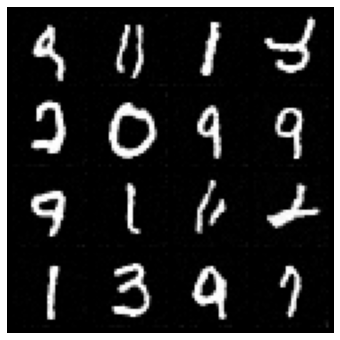

In [7]:
device = 'cpu'
score_model = torch.nn.DataParallel(MNIST_ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)


ckpt = torch.load('models/MNIST.pth', map_location=device)
score_model.load_state_dict(ckpt)

sampler = pc_sampler 

samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 16)


samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

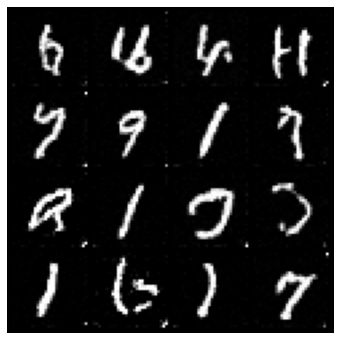

In [8]:
ckpt = torch.load('models/MNIST.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 
sampler = Euler_Maruyama_sampler 

samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=16)


samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [3]:
test_data = MNIST('./data', train=False, transform=transforms.ToTensor())

In [4]:
zero = test_data[3][0][0]
three = test_data[30][0][0]
five = test_data[23][0][0]
four = test_data[27][0][0]

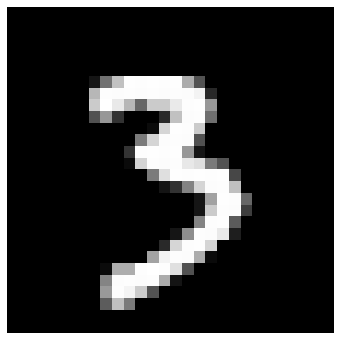

In [11]:
grid = make_grid(test_data[30][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

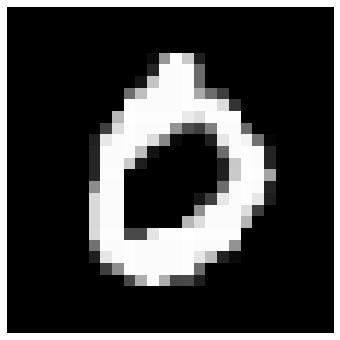

In [12]:
grid = make_grid(test_data[3][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

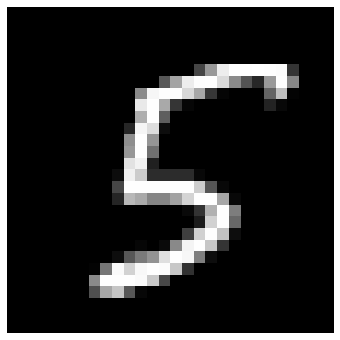

In [13]:
grid = make_grid(test_data[23][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

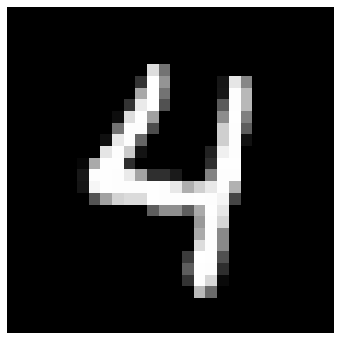

In [14]:
grid = make_grid(test_data[27][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# Replacement method

In [6]:
zero_diff = get_diffused_MNIST(zero, 1000, sde_VE)

In [7]:
three_diff = get_diffused_MNIST(three, 1000, sde_VE)

In [8]:
four_diff = get_diffused_MNIST(four, 1000, sde_VE)

In [9]:
five_diff = get_diffused_MNIST(five, 1000, sde_VE)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/harryamad/Google Drive/2022/Dissertation/conditional_diffusion_simulation/SDE.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


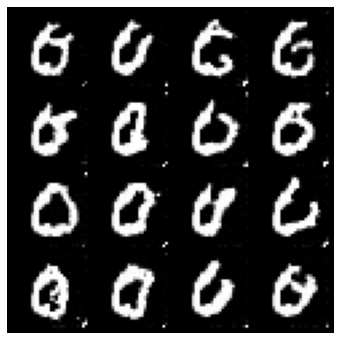

In [10]:
device = 'cpu'
score_model = torch.nn.DataParallel(MNIST_ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
ckpt = torch.load('models/MNIST.pth', map_location=device)
score_model.load_state_dict(ckpt)

samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diff, batch_size=16)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

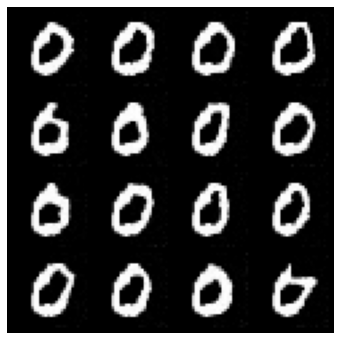

In [11]:
samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diff, batch_size=16)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


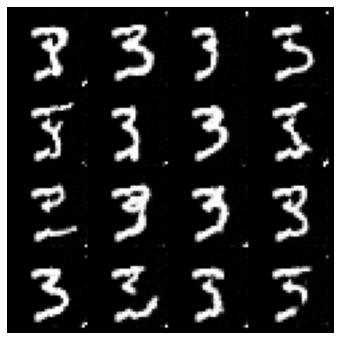

In [121]:
three_samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diff)

three_samples = three_samples.clamp(0.0, 1.0)
three_sample_grid = make_grid(three_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(three_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


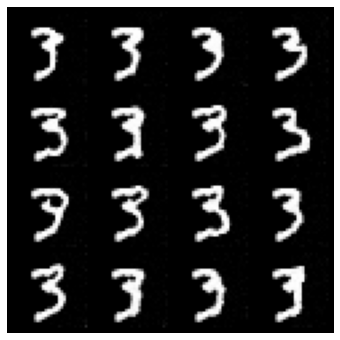

In [122]:
three_samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diff)

three_samples = three_samples.clamp(0.0, 1.0)
three_sample_grid = make_grid(three_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(three_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


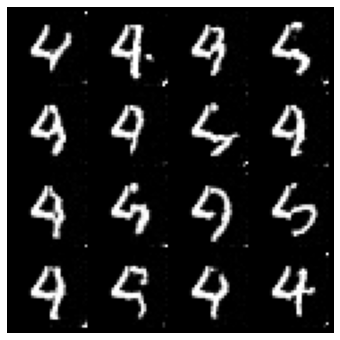

In [128]:
four_samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, four, diffused_y = four_diff)

four_samples = four_samples.clamp(0.0, 1.0)
four_sample_grid = make_grid(four_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(four_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


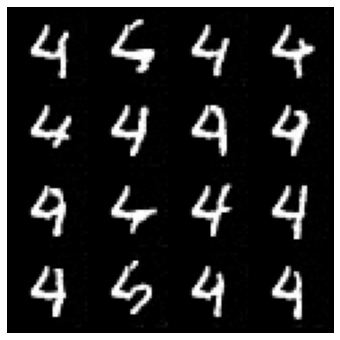

In [129]:
four_samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, four, diffused_y = four_diff)

four_samples = four_samples.clamp(0.0, 1.0)
four_sample_grid = make_grid(four_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(four_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


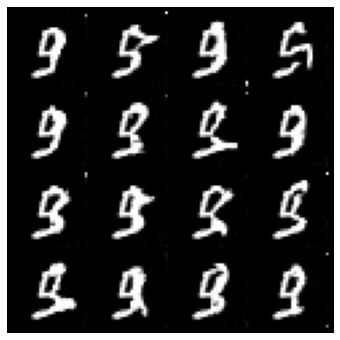

In [152]:
five_samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, five, diffused_y = five_diff)

five_samples = five_samples.clamp(0.0, 1.0)
five_sample_grid = make_grid(five_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(five_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


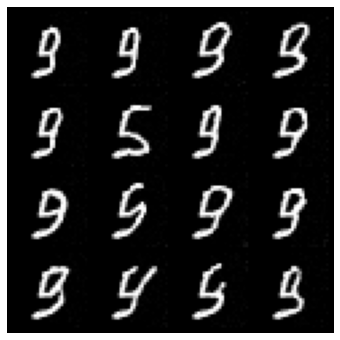

In [134]:
five_samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, five, diffused_y = five_diff)

five_samples = five_samples.clamp(0.0, 1.0)
five_sample_grid = make_grid(five_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(five_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# SMCDiff

  0%|          | 0/1000 [00:00<?, ?it/s]

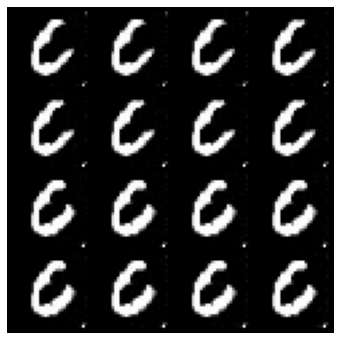

In [12]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         zero, diffused_y = zero_diff, k=16)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

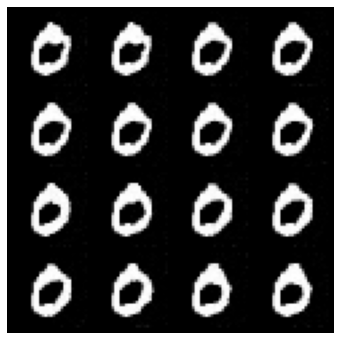

In [13]:
samples = SMCDiff_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         zero, diffused_y = zero_diff, k=16)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


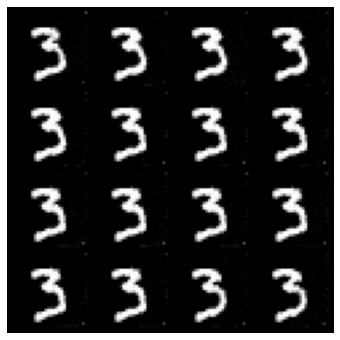

In [137]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         three, diffused_y = three_diff, k=16)


samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


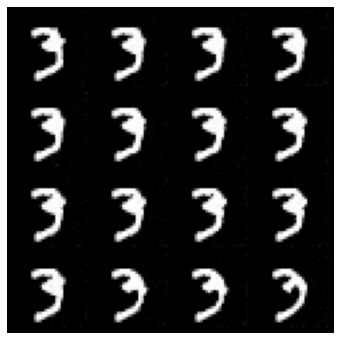

In [138]:
samples = SMCDiff_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         three, diffused_y = three_diff, k=16)


samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


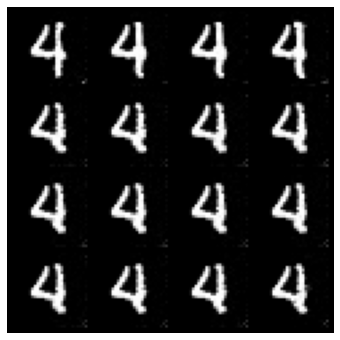

In [142]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         four, diffused_y = four_diff, k=16)


samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


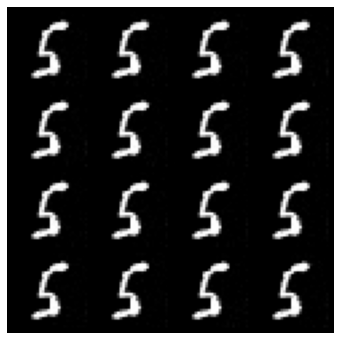

In [151]:
samples = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         five, diffused_y = five_diff, k=16)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [54]:
zero_diffs = [get_diffused(zero, 1000, sde_VE, sigma_min, sigma_max) for i in range(16)]

In [66]:
cdiffe_sample = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[0], batch_size=1)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [67]:
for i in range(1,16):
    sample = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[i], batch_size=1)
    cdiffe_sample = torch.vstack([cdiffe_sample, sample])

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

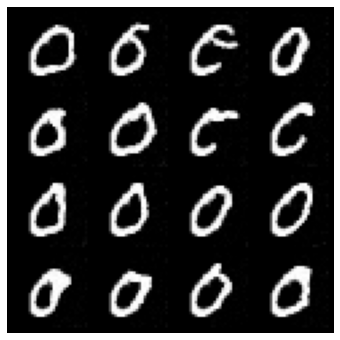

In [68]:
cdiffe_sample = cdiffe_sample.clamp(0.0, 1.0)
sample_grid = make_grid(cdiffe_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [73]:
smcdiff_sample = SMCDiff_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[0], k=16)[0]


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [74]:
for i in range(1,16):
    sample = SMCDiff_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, diffused_y = zero_diffs[i], k=16)[0]
    smcdiff_sample = torch.vstack([smcdiff_sample, sample])
    
smcdiff_sample = smcdiff_sample[:,None,:,:]

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

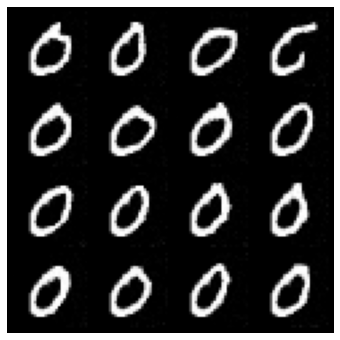

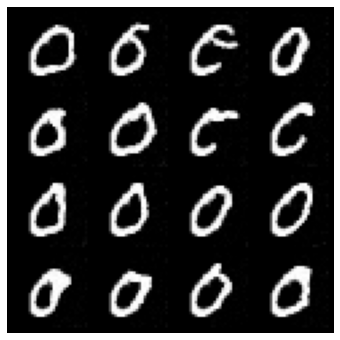

In [75]:
smcdiff_sample = smcdiff_sample.clamp(0.0, 1.0)
smcdiff_sample_grid = make_grid(smcdiff_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(smcdiff_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

cdiffe_sample = cdiffe_sample.clamp(0.0, 1.0)
sample_grid = make_grid(cdiffe_sample, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

#cde_sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

##plt.figure(figsize=(6,6))
#plt.axis('off')
#plt.imshow(cde_sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#plt.show()

In [76]:
#torch.save(smcdiff_sample, 'data/smcdiff_zero.pt')

In [77]:
#torch.save(cdiffe_sample, 'data/cdiffe_zero.pt')

In [78]:
three_diffs = [get_diffused(three, 1000, sde_VE, sigma_min, sigma_max) for i in range(16)]

In [79]:
cdiffe_sample_3 = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diffs[0], batch_size=1)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [80]:
for i in range(1,16):
    sample = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diffs[i], batch_size=1)
    cdiffe_sample_3 = torch.vstack([cdiffe_sample_3, sample])

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

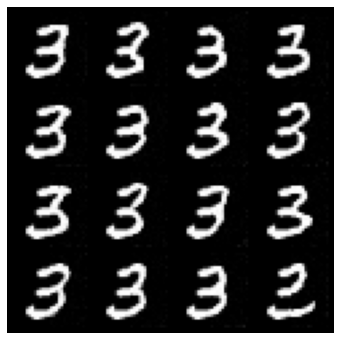

In [81]:
cdiffe_sample_3 = cdiffe_sample_3.clamp(0.0, 1.0)
sample_grid = make_grid(cdiffe_sample_3, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [171]:
smcdiff_sample_3 = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diffs[0], k=16)[0]


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


981 resampling, departure=12.43
965 resampling, departure=12.20
945 resampling, departure=12.18
915 resampling, departure=12.05
891 resampling, departure=12.36
865 resampling, departure=12.65
845 resampling, departure=12.42
825 resampling, departure=12.45
809 resampling, departure=12.05
797 resampling, departure=12.12
785 resampling, departure=12.17
763 resampling, departure=12.10
746 resampling, departure=12.37
730 resampling, departure=12.53
717 resampling, departure=12.15
704 resampling, departure=12.51
678 resampling, departure=12.55
670 resampling, departure=12.24
662 resampling, departure=14.42
650 resampling, departure=14.12
646 resampling, departure=13.87
628 resampling, departure=13.32
621 resampling, departure=12.15
615 resampling, departure=12.78
603 resampling, departure=14.94
595 resampling, departure=12.51
589 resampling, departure=12.93
579 resampling, departure=12.45
576 resampling, departure=14.86
571 resampling, departure=13.20
568 resampling, departure=12.42
564 resa

In [175]:
for i in range(1,16):
    sample = SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, diffused_y = three_diffs[i], k=16)[0]
    smcdiff_sample_3 = torch.vstack([smcdiff_sample_3, sample])
    
smcdiff_sample_3 = smcdiff_sample_3[:,None,:,:]

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cf0b9f4fb144>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


990 resampling, departure=12.01
975 resampling, departure=12.21
959 resampling, departure=12.46
936 resampling, departure=12.39
917 resampling, departure=12.00
882 resampling, departure=12.05
862 resampling, departure=12.96
844 resampling, departure=12.01
822 resampling, departure=12.18
805 resampling, departure=12.04
778 resampling, departure=12.65
757 resampling, departure=12.80
729 resampling, departure=12.45
717 resampling, departure=12.78
699 resampling, departure=13.00
686 resampling, departure=12.08
669 resampling, departure=12.24
658 resampling, departure=12.78
654 resampling, departure=13.30
644 resampling, departure=12.06
638 resampling, departure=12.98
630 resampling, departure=12.81
616 resampling, departure=12.34
605 resampling, departure=12.04
595 resampling, departure=13.79
587 resampling, departure=12.46
581 resampling, departure=15.87
574 resampling, departure=13.43
569 resampling, departure=12.64
553 resampling, departure=12.27
545 resampling, departure=13.13
539 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

990 resampling, departure=12.14
970 resampling, departure=12.24
944 resampling, departure=12.02
933 resampling, departure=12.42
913 resampling, departure=12.16
897 resampling, departure=12.03
878 resampling, departure=12.41
862 resampling, departure=12.34
839 resampling, departure=12.87
823 resampling, departure=12.07
813 resampling, departure=12.73
797 resampling, departure=12.17
775 resampling, departure=12.58
759 resampling, departure=12.05
738 resampling, departure=13.22
722 resampling, departure=12.95
711 resampling, departure=12.56
698 resampling, departure=12.09
677 resampling, departure=12.42
666 resampling, departure=13.77
649 resampling, departure=13.87
632 resampling, departure=14.98
611 resampling, departure=14.81
603 resampling, departure=14.73
590 resampling, departure=12.86
584 resampling, departure=12.96
576 resampling, departure=13.25
566 resampling, departure=14.25
558 resampling, departure=14.69
548 resampling, departure=12.50
537 resampling, departure=12.44
530 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

989 resampling, departure=12.42
973 resampling, departure=12.27
944 resampling, departure=12.17
917 resampling, departure=12.28
901 resampling, departure=13.11
877 resampling, departure=12.21
858 resampling, departure=12.08
837 resampling, departure=12.19
815 resampling, departure=12.21
794 resampling, departure=12.27
780 resampling, departure=12.22
765 resampling, departure=12.66
745 resampling, departure=12.36
720 resampling, departure=12.94
701 resampling, departure=13.15
693 resampling, departure=15.06
667 resampling, departure=14.93
653 resampling, departure=12.39
637 resampling, departure=15.71
622 resampling, departure=12.20
609 resampling, departure=12.02
601 resampling, departure=15.36
590 resampling, departure=12.84
584 resampling, departure=12.15
579 resampling, departure=13.05
577 resampling, departure=12.92
570 resampling, departure=12.37
564 resampling, departure=13.16
560 resampling, departure=12.87
556 resampling, departure=12.02
548 resampling, departure=12.79
545 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

989 resampling, departure=12.54
968 resampling, departure=12.02
950 resampling, departure=12.16
930 resampling, departure=12.39
909 resampling, departure=12.19
893 resampling, departure=12.21
880 resampling, departure=12.39
847 resampling, departure=12.03
833 resampling, departure=12.35
807 resampling, departure=12.31
783 resampling, departure=12.36
765 resampling, departure=12.18
742 resampling, departure=12.11
719 resampling, departure=12.64
709 resampling, departure=12.13
697 resampling, departure=15.37
686 resampling, departure=12.79
671 resampling, departure=12.31
656 resampling, departure=12.10
651 resampling, departure=13.25
643 resampling, departure=12.24
634 resampling, departure=13.79
621 resampling, departure=13.87
615 resampling, departure=13.33
607 resampling, departure=12.56
600 resampling, departure=12.86
591 resampling, departure=13.90
585 resampling, departure=14.51
573 resampling, departure=13.53
565 resampling, departure=15.43
560 resampling, departure=13.88
549 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

990 resampling, departure=12.27
968 resampling, departure=12.22
944 resampling, departure=12.33
903 resampling, departure=12.34
870 resampling, departure=12.07
856 resampling, departure=12.38
838 resampling, departure=12.22
828 resampling, departure=12.20
804 resampling, departure=12.43
788 resampling, departure=12.04
768 resampling, departure=12.90
753 resampling, departure=12.24
740 resampling, departure=12.47
727 resampling, departure=12.31
717 resampling, departure=13.66
701 resampling, departure=12.16
686 resampling, departure=12.61
673 resampling, departure=12.76
664 resampling, departure=12.65
657 resampling, departure=12.75
652 resampling, departure=13.87
646 resampling, departure=12.43
643 resampling, departure=13.37
626 resampling, departure=13.92
609 resampling, departure=13.76
602 resampling, departure=12.56
594 resampling, departure=14.31
588 resampling, departure=12.23
582 resampling, departure=12.70
574 resampling, departure=15.33
565 resampling, departure=12.56
558 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

991 resampling, departure=12.35
977 resampling, departure=12.38
959 resampling, departure=12.02
947 resampling, departure=12.11
931 resampling, departure=12.45
917 resampling, departure=12.27
896 resampling, departure=12.04
873 resampling, departure=12.04
854 resampling, departure=12.46
837 resampling, departure=12.07
824 resampling, departure=13.04
807 resampling, departure=12.78
789 resampling, departure=12.55
773 resampling, departure=12.31
765 resampling, departure=12.07
746 resampling, departure=12.64
728 resampling, departure=12.47
721 resampling, departure=12.20
703 resampling, departure=13.39
687 resampling, departure=12.24
675 resampling, departure=13.24
662 resampling, departure=13.66
652 resampling, departure=12.58
635 resampling, departure=14.15
623 resampling, departure=13.59
612 resampling, departure=13.29
604 resampling, departure=17.16
597 resampling, departure=13.27
591 resampling, departure=13.55
581 resampling, departure=14.05
569 resampling, departure=12.61
562 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

988 resampling, departure=12.50
972 resampling, departure=12.99
957 resampling, departure=12.08
933 resampling, departure=12.35
892 resampling, departure=12.40
869 resampling, departure=12.66
846 resampling, departure=12.14
827 resampling, departure=12.40
810 resampling, departure=12.15
792 resampling, departure=12.59
778 resampling, departure=12.87
763 resampling, departure=12.34
752 resampling, departure=12.39
728 resampling, departure=12.64
702 resampling, departure=13.31
691 resampling, departure=12.38
678 resampling, departure=12.65
671 resampling, departure=12.99
663 resampling, departure=15.20
650 resampling, departure=12.82
640 resampling, departure=13.22
630 resampling, departure=14.83
618 resampling, departure=14.59
608 resampling, departure=12.23
601 resampling, departure=16.36
592 resampling, departure=12.21
586 resampling, departure=12.39
577 resampling, departure=13.55
571 resampling, departure=12.41
558 resampling, departure=12.01
556 resampling, departure=13.42
548 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

986 resampling, departure=12.64
966 resampling, departure=12.17
941 resampling, departure=12.03
914 resampling, departure=12.37
895 resampling, departure=12.82
882 resampling, departure=12.16
857 resampling, departure=12.18
835 resampling, departure=12.05
820 resampling, departure=12.31
804 resampling, departure=12.77
785 resampling, departure=13.13
774 resampling, departure=12.88
760 resampling, departure=13.23
745 resampling, departure=12.38
732 resampling, departure=12.53
717 resampling, departure=12.07
706 resampling, departure=12.80
695 resampling, departure=13.17
679 resampling, departure=12.79
661 resampling, departure=13.59
655 resampling, departure=14.69
644 resampling, departure=12.81
633 resampling, departure=13.73
624 resampling, departure=12.92
619 resampling, departure=13.95
607 resampling, departure=13.41
601 resampling, departure=14.23
589 resampling, departure=12.36
588 resampling, departure=19.46
585 resampling, departure=16.65
581 resampling, departure=12.70
575 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

990 resampling, departure=12.80
974 resampling, departure=12.44
952 resampling, departure=12.24
927 resampling, departure=12.47
905 resampling, departure=12.14
880 resampling, departure=12.81
860 resampling, departure=12.32
842 resampling, departure=12.57
827 resampling, departure=12.06
806 resampling, departure=12.01
780 resampling, departure=12.97
757 resampling, departure=12.39
738 resampling, departure=12.23
719 resampling, departure=13.19
706 resampling, departure=12.85
688 resampling, departure=13.44
679 resampling, departure=13.44
663 resampling, departure=12.28
654 resampling, departure=12.03
644 resampling, departure=13.14
629 resampling, departure=12.50
615 resampling, departure=12.83
605 resampling, departure=13.90
595 resampling, departure=13.31
588 resampling, departure=12.41
581 resampling, departure=12.11
577 resampling, departure=12.77
568 resampling, departure=12.19
555 resampling, departure=15.69
547 resampling, departure=12.08
543 resampling, departure=12.24
534 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

991 resampling, departure=12.27
979 resampling, departure=12.07
962 resampling, departure=12.31
937 resampling, departure=12.18
902 resampling, departure=12.14
877 resampling, departure=12.16
859 resampling, departure=12.03
841 resampling, departure=12.42
824 resampling, departure=13.14
789 resampling, departure=12.39
770 resampling, departure=12.96
755 resampling, departure=13.17
733 resampling, departure=12.95
723 resampling, departure=12.41
713 resampling, departure=12.09
692 resampling, departure=12.48
673 resampling, departure=13.37
663 resampling, departure=13.16
649 resampling, departure=13.90
638 resampling, departure=12.38
632 resampling, departure=13.11
622 resampling, departure=13.62
608 resampling, departure=12.81
601 resampling, departure=13.51
586 resampling, departure=13.11
580 resampling, departure=13.26
574 resampling, departure=14.34
565 resampling, departure=13.11
560 resampling, departure=12.28
557 resampling, departure=13.31
551 resampling, departure=15.73
541 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

982 resampling, departure=12.09
958 resampling, departure=12.26
942 resampling, departure=12.43
927 resampling, departure=12.43
910 resampling, departure=12.62
896 resampling, departure=12.79
871 resampling, departure=12.23
848 resampling, departure=12.28
823 resampling, departure=13.10
797 resampling, departure=13.42
785 resampling, departure=12.98
767 resampling, departure=12.58
756 resampling, departure=12.38
745 resampling, departure=13.60
734 resampling, departure=12.26
717 resampling, departure=12.34
695 resampling, departure=12.36
688 resampling, departure=12.01
671 resampling, departure=12.61
651 resampling, departure=13.52
644 resampling, departure=12.36
638 resampling, departure=12.26
625 resampling, departure=12.98
618 resampling, departure=13.94
608 resampling, departure=12.36
593 resampling, departure=12.26
582 resampling, departure=13.58
576 resampling, departure=12.49
569 resampling, departure=12.11
563 resampling, departure=12.90
555 resampling, departure=14.83
539 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

989 resampling, departure=12.40
970 resampling, departure=12.13
938 resampling, departure=12.20
917 resampling, departure=12.02
898 resampling, departure=12.14
886 resampling, departure=12.19
869 resampling, departure=12.22
853 resampling, departure=12.16
836 resampling, departure=12.26
820 resampling, departure=12.11
806 resampling, departure=12.43
787 resampling, departure=13.20
772 resampling, departure=12.45
751 resampling, departure=12.03
734 resampling, departure=12.55
723 resampling, departure=12.53
712 resampling, departure=12.17
696 resampling, departure=12.08
686 resampling, departure=12.28
673 resampling, departure=12.24
657 resampling, departure=12.84
648 resampling, departure=12.40
641 resampling, departure=12.67
633 resampling, departure=14.57
624 resampling, departure=12.41
611 resampling, departure=17.36
597 resampling, departure=14.75
589 resampling, departure=14.86
585 resampling, departure=12.50
578 resampling, departure=16.64
569 resampling, departure=13.14
560 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

991 resampling, departure=12.01
981 resampling, departure=12.15
962 resampling, departure=12.02
949 resampling, departure=12.04
924 resampling, departure=12.35
906 resampling, departure=12.04
886 resampling, departure=12.30
866 resampling, departure=12.87
852 resampling, departure=12.52
822 resampling, departure=12.01
802 resampling, departure=13.07
785 resampling, departure=12.06
770 resampling, departure=12.16
758 resampling, departure=12.59
738 resampling, departure=12.37
718 resampling, departure=13.54
703 resampling, departure=13.07
692 resampling, departure=13.76
678 resampling, departure=12.72
662 resampling, departure=12.10
653 resampling, departure=12.09
640 resampling, departure=12.27
635 resampling, departure=15.17
625 resampling, departure=12.20
614 resampling, departure=13.33
605 resampling, departure=13.95
594 resampling, departure=17.26
585 resampling, departure=12.98
575 resampling, departure=12.44
568 resampling, departure=14.84
563 resampling, departure=12.23
561 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

991 resampling, departure=12.63
973 resampling, departure=12.16
945 resampling, departure=12.05
922 resampling, departure=12.07
893 resampling, departure=12.44
870 resampling, departure=12.45
845 resampling, departure=12.14
831 resampling, departure=13.22
810 resampling, departure=12.33
794 resampling, departure=12.23
771 resampling, departure=12.09
753 resampling, departure=14.46
736 resampling, departure=13.08
725 resampling, departure=13.67
715 resampling, departure=13.39
697 resampling, departure=13.57
684 resampling, departure=12.70
662 resampling, departure=12.36
652 resampling, departure=12.78
643 resampling, departure=13.12
635 resampling, departure=12.08
632 resampling, departure=12.13
621 resampling, departure=12.52
614 resampling, departure=16.76
607 resampling, departure=14.90
604 resampling, departure=12.61
602 resampling, departure=12.43
594 resampling, departure=13.54
585 resampling, departure=12.34
581 resampling, departure=12.72
574 resampling, departure=12.40
564 resa

  0%|          | 0/1000 [00:00<?, ?it/s]

982 resampling, departure=12.36
960 resampling, departure=12.72
940 resampling, departure=12.03
916 resampling, departure=12.23
899 resampling, departure=12.08
887 resampling, departure=12.03
865 resampling, departure=12.35
835 resampling, departure=12.05
822 resampling, departure=12.57
794 resampling, departure=12.82
781 resampling, departure=12.31
759 resampling, departure=12.45
739 resampling, departure=12.33
727 resampling, departure=12.66
721 resampling, departure=12.50
707 resampling, departure=12.95
693 resampling, departure=12.87
672 resampling, departure=12.23
666 resampling, departure=15.32
661 resampling, departure=14.66
657 resampling, departure=12.95
642 resampling, departure=12.79
638 resampling, departure=12.83
628 resampling, departure=12.63
618 resampling, departure=12.29
602 resampling, departure=12.05
598 resampling, departure=17.01
594 resampling, departure=13.50
587 resampling, departure=12.38
576 resampling, departure=14.33
570 resampling, departure=12.22
563 resa

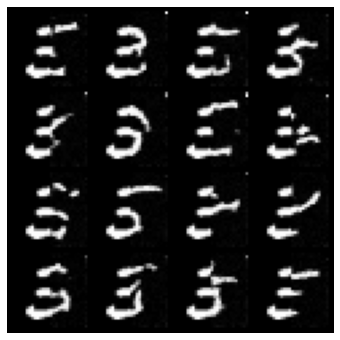

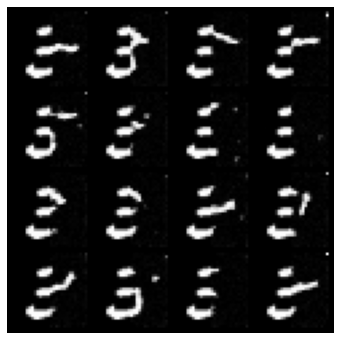

In [177]:
cdiffe_sample_3 = cdiffe_sample_3.clamp(0.0, 1.0)
sample_grid = make_grid(cdiffe_sample_3, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

smcdiff_sample_3 = smcdiff_sample_3.clamp(0.0, 1.0)
sample_grid = make_grid(smcdiff_sample_3, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [178]:
#torch.save(cdiffe_sample_3, 'data/cdiffe_three.pt')

In [179]:
#torch.save(smcdiff_sample_3, 'data/smcdiff_three.pt')

# Tailored conditional method

In [14]:
ckpt = torch.load('models/MNIST_cde.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

  0%|          | 0/1000 [00:00<?, ?it/s]

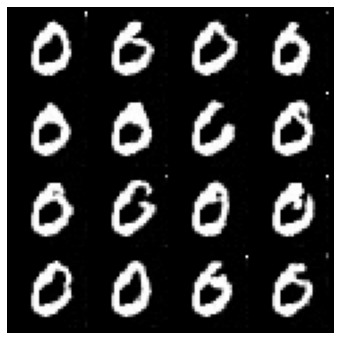

In [15]:
cde_samples = CDE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, batch_size=16)

cde_samples = cde_samples.clamp(0.0, 1.0)
sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

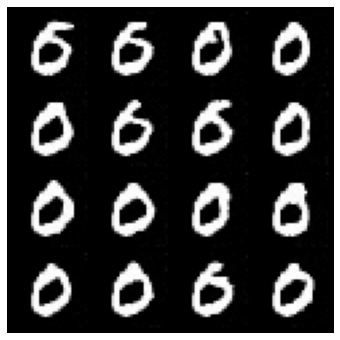

In [16]:
cde_samples = CDE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, zero, batch_size=16)

cde_samples = cde_samples.clamp(0.0, 1.0)
sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


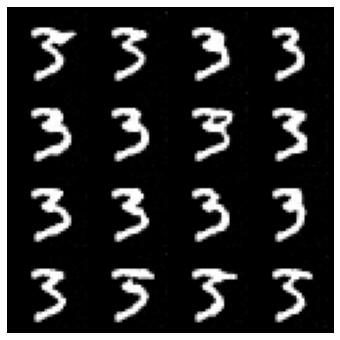

In [148]:
cde_samples = CDE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, three, batch_size=16)

cde_samples = cde_samples.clamp(0.0, 1.0)
sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


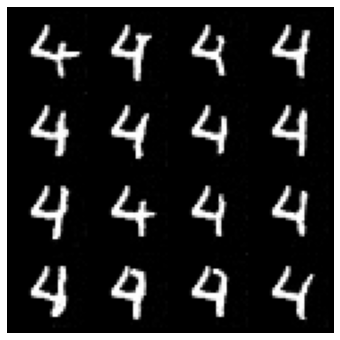

In [149]:
cde_samples = CDE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, four, batch_size=16)

cde_samples = cde_samples.clamp(0.0, 1.0)
sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-cbcb7aac467b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


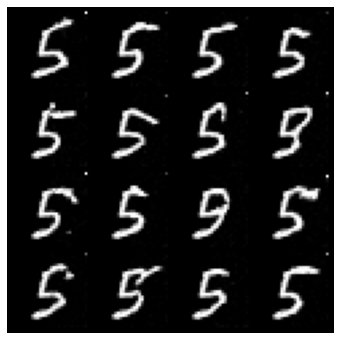

In [153]:
cde_samples = CDE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, five, batch_size=16)

cde_samples = cde_samples.clamp(0.0, 1.0)
sample_grid = make_grid(cde_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [163]:
#torch.save(cde_samples, 'data/cde_zero.pt')

In [164]:
#torch.save(cde_samples_3, 'data/cde_three.pt')